# Evaluating performance of biometric systems
This assignment focusses on evaluating the performance of any biometric system in a verification and identification setting. This assignment will give you insight into the way biometrics systems are evaluated from a performance point of view. Make sure you can properly distinguish the two cases and apply the proper validation procedures. 

* **Verification (a.k.a. authentication)**: authenticating a claimed identity (is this person who he/she claims to be?).

* **Identification**: associate a particular individual with an identity (who is this unidentified individual?)

**The solutions in this assignment are just skeleton examples. Please adapt them where needed.**

Write your code such that you can easily reuse it for the following assignments where you will implement small biometric systems and test them. Many operations have already been implemented in [SciPy](https://docs.scipy.org/doc/numpy/index.html), feel free to use them or any other unless specified otherwise in the assignment.  

In [1]:
# import the required python packages

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import BSSR1

## Realistic validation database

For this experiment we will make use of actual fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (imposter scores). 

The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the fing-x-fing subfolder. 


### Read the BSSR1 scores and convert them to a manageable format

We provide you here with the code to read the scores from the files. Normally you don't need to change this code. 

The scores are first converted to a similarity matrix with the genuine scores on the diagonal and the imposter scores on the off-diagonal elements. For more information on how these data are structured on file, see: [readme](./fing_x_fing/README.html).

Next,if necessary to reduce calculation times, they can be subsampled. 

Finally, the original (subsampled) scores are converted to a linear list of scores with associated labels of genuine or imposter, which simplifies their use in [scikit-learn](https://scikit-learn.org/stable/index.html) for evaluation.

In [2]:
## provide links to the relevant files

# set paths to files containing identity tags of enrollees and users
li_enrollees_id_filepath = './fing_x_fing/sets/dos/li/enrollees.xml'
li_users_id_filepath = './fing_x_fing/sets/dos/li/users.xml'
# set list string for scores files
li_scores_list_str = './fing_x_fing/sims/dos/li/V/*.bin'

ri_enrollees_id_filepath = './fing_x_fing/sets/dos/ri/enrollees.xml'
ri_users_id_filepath = './fing_x_fing/sets/dos/ri/users.xml'
# set list string for scores filesr
ri_scores_list_str = './fing_x_fing/sims/dos/ri/V/*.bin'

In [3]:
# read BSSR1 scores (this might take a while)
(li_fingxfing_dataframe, li_enrollees, li_users, li_column_names) = BSSR1.read_BSSR1_scores_from_file(li_enrollees_id_filepath, li_users_id_filepath, li_scores_list_str)

In [4]:
(ri_fingxfing_dataframe, ri_enrollees, ri_users, ri_column_names) = BSSR1.read_BSSR1_scores_from_file(ri_enrollees_id_filepath, ri_users_id_filepath, ri_scores_list_str)

In [5]:
# subsample the scores to a manageable number of individuals
li_similarity_matrix = BSSR1.df2sim_subsample(li_fingxfing_dataframe, column_names = li_column_names, nr_individuals = 1000)

In [6]:
# subsample the scores to a manageable number of individuals
ri_similarity_matrix = BSSR1.df2sim_subsample(ri_fingxfing_dataframe, column_names = ri_column_names, nr_individuals = 1000)

In [7]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)

In [8]:
# convert to genuine and imposter scores, the *_genuine_id provides a mask for the genuine scores
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

## Validation of verification system
In an authentication scenario, one has a binary classification problem: is it the claimed identity or not? We thus have two classes: genuine and imposter

### Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of these systems can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1). 

#### 1. Genuine and imposter score distributions

From the previously calculated genuine and impostor scores for the available data, first generate and plot the genuine and impostor score distributions: 

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>



#### <font color=blue> Task 1.1 Plot and describe the score distributions

* Plot the genuine and imposter score distributions in a single plot.
* Do you need to normalize the distributions? Why (not)?
* Describe qualitatively this combined plot (hint: limit the score range for better understanding)
</font>

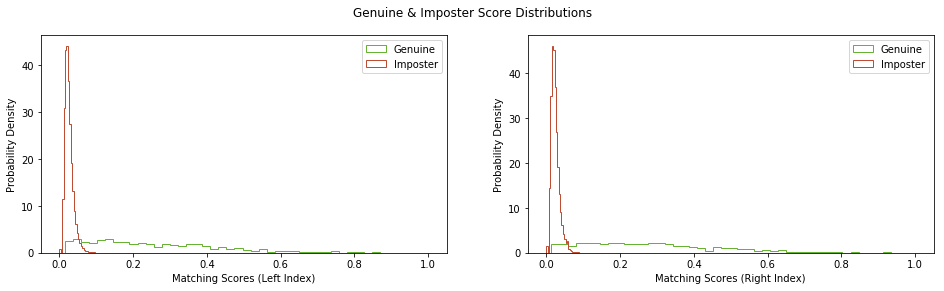

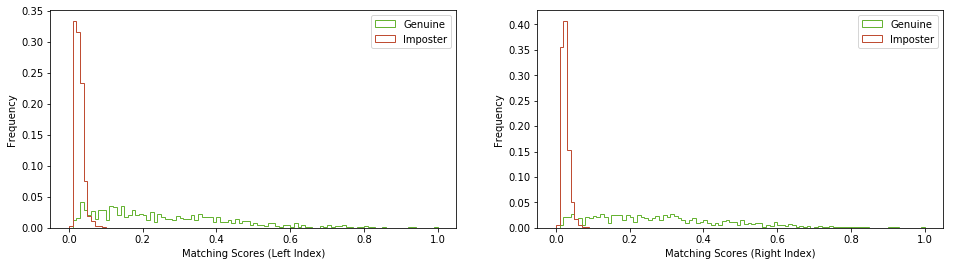

In [13]:
"""Plot the genuine and imposter score distributions."""

# The picture of distributions given above and in Jain says 'probability' on the y-axis,
#  but this is not a probability. Hereunder, both a pdf and frequencies are plotted.
#  The pdf is easier to interpret.
def to_weights(array):
    return np.ones_like(array) / float(len(array))
li_genuine_weights = to_weights(li_scores[li_genuine_id > 0])
li_imposter_weights = to_weights(li_scores[li_genuine_id < 1])
ri_genuine_weights = to_weights(ri_scores[ri_genuine_id > 0])
ri_imposter_weights = to_weights(ri_scores[ri_genuine_id < 1])

# Probability density functions
kwargs = dict(histtype='step', density=True, bins=45)
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('Genuine & Imposter Score Distributions')
axes[0].hist(li_scores[li_genuine_id > 0], color=(0.4,0.7,0.2), label='Genuine', **kwargs)
axes[0].hist(li_scores[li_genuine_id < 1], color=(0.75,0.3,0.2), label='Imposter', **kwargs)
axes[0].set(xlabel='Matching Scores (Left Index)', ylabel='Probability Density')
axes[0].legend();
axes[1].hist(ri_scores[ri_genuine_id > 0], color=(0.4,0.7,0.2), label='Genuine', **kwargs)
axes[1].hist(ri_scores[ri_genuine_id < 1], color=(0.75,0.3,0.2), label='Imposter', **kwargs)
axes[1].legend();
axes[1].set(xlabel='Matching Scores (Right Index)', ylabel='Probability Density')
plt.show()

# Plot frequencies
kwargs = dict(histtype='step', density=False, bins=np.arange(0.0, 1.01, 0.01)) # bins=45 for fixed nr. of bins
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
axes[0].hist(li_scores[li_genuine_id > 0], weights=li_genuine_weights, color=(0.4,0.7,0.2), label='Genuine', **kwargs)
axes[0].hist(li_scores[li_genuine_id < 1], weights=li_imposter_weights, color=(0.75,0.3,0.2), label='Imposter', **kwargs)
axes[0].set(xlabel='Matching Scores (Left Index)', ylabel='Frequency')
axes[0].legend();
axes[1].hist(ri_scores[ri_genuine_id > 0], weights=ri_genuine_weights, color=(0.4,0.7,0.2), label='Genuine', **kwargs)
axes[1].hist(ri_scores[ri_genuine_id < 1], weights=ri_imposter_weights, color=(0.75,0.3,0.2), label='Imposter', **kwargs)
axes[1].legend();
axes[1].set(xlabel='Matching Scores (Right Index)', ylabel='Frequency')
plt.show()

*The distributions do need to be normalised as there are many more imposter scores than genuine scores (1000 vs. 999000). Genuine scores are more varied but tend to be higher. There's no high imposter score, most of the imposter scores are at the very low end of the scale.*

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

False Match/Acceptance Rates (FMR/FAR), False Non-Match/Rejections Rates (FNMR/FRR) and Genuine Acceptance Rate (GAR)/True Match Rate (TMR) are calculated given the impostor $p(s | I)$ and genuine $p(s | G) $ probability distributions for every match score threshold value $\eta$. 

Given a set of match scores corresponding to the genuine class G and a set of match scores from the imposter class I this comes down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta) 
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s \geq \eta) 
$$
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta)
$$

<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a ([Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR),  sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="400" height="auto" align="center"/>

#### <font color=blue> Task 1.2 Plot and discuss ROC curve 

* Calculate FPR, TPR from the matching scores.
* Plot FAR and FRR as a function of matching scores.
* Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe? 
* Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?

Use the [scikit-learn](https://scikit-learn.org/stable/index.html) package, which contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</font>

In [30]:
from sklearn.metrics import roc_curve

In [31]:
"""Calculate FPR, TPR from the matching scores."""
#default = 0.6
#def fpr(imposter_scores=li_scores[li_genuine_id < 1], threshold=default):
#    return len(imposter_scores[imposter_scores >= threshold]) / float(len(imposter_scores))
#def tpr(genuine_scores=li_scores[li_genuine_id > 0], threshold=default):
#    return len(genuine_scores[genuine_scores >= threshold]) / float(len(genuine_scores))
#print("FPR (threshold = % .1f) : % f" % (default, fpr()))
#print("TPR (threshold = % .1f) : % f" % (default, tpr()))
li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

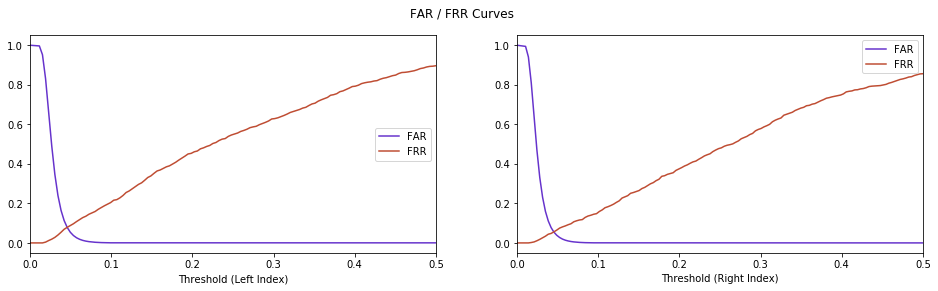

In [32]:
"""Plot FAR and FRR as a function of matching scores."""
#thresholds = np.linspace(0.0,1.0,100).tolist()
#li_far = [fpr(threshold=t) for t in thresholds]
#li_frr = [1 - tpr(threshold=t) for t in thresholds]
#ri_imposter_scores = li_scores[li_genuine_id < 1]
#ri_genuine_scores = li_scores[li_genuine_id > 0]
#ri_far = [fpr(ri_imposter_scores, t) for t in thresholds]
#ri_frr = [1 - tpr(ri_genuine_scores, t) for t in thresholds]
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('FAR / FRR Curves')
axes[0].plot(li_thresholds, li_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[0].plot(li_thresholds, 1-li_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].plot(ri_thresholds, ri_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[1].plot(ri_thresholds, 1-ri_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();

*These plots clearly correspond to the distributions. As the threshold rises, the probability of false matches steadily decreases, whereas the probability of false rejections increases more slowly as the genuine scores are more spread out.*

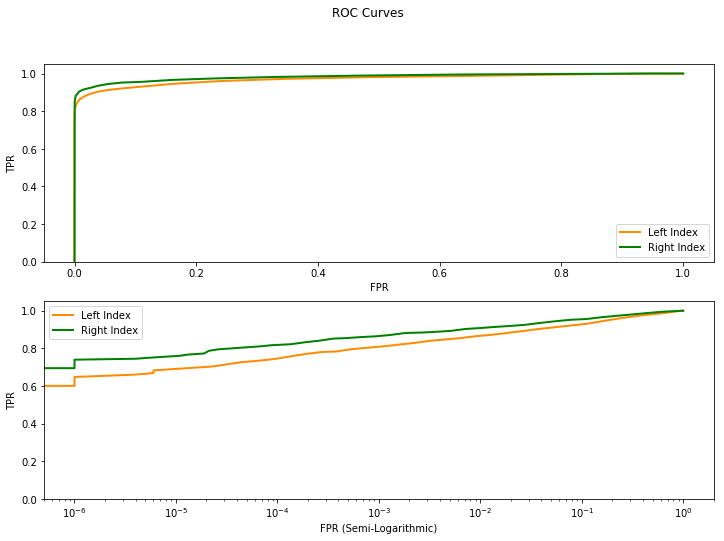

In [42]:
"""Plot the ROC curve (TPR against the FPR for different threshold values)"""
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
figure.suptitle('ROC Curves')
axes[0].plot(li_fpr, li_tpr, color='darkorange', lw=2, label='Left Index')
axes[0].plot(ri_fpr, ri_tpr, color='green', lw=2, label='Right Index')
axes[0].set(xlabel='FPR', ylabel='TPR', ylim=[0.0,1.05])
axes[0].legend();
axes[1].semilogx(li_fpr, li_tpr, color='darkorange', lw=2, label='Left Index')
axes[1].semilogx(ri_fpr, ri_tpr, color='green', lw=2, label='Right Index')
axes[1].set(xlabel='FPR (Semi-Logarithmic)', ylabel='TPR', ylim=[0.0,1.05])
axes[1].legend();
plt.show()

*As the threshold increases the ratio of true positives rises sharply whereas the ratio of false matches doesn't. After that, the curve doesn't change that much anymore. This is due to class imbalance. A logarithmic scale helps as it accentuates the differences in TPR for the higher FP rates.*

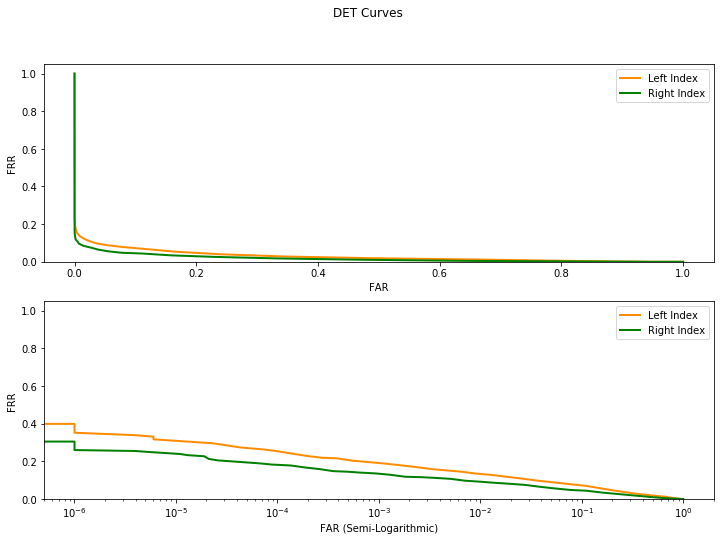

In [44]:
"""Plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
figure.suptitle('DET Curves')
axes[0].plot(li_fpr, 1-li_tpr, color='darkorange', lw=2, label='Left Index')
axes[0].plot(ri_fpr, 1-ri_tpr, color='green', lw=2, label='Right Index')
axes[0].set(xlabel='FAR', ylabel='FRR', ylim=[0.0,1.05])
axes[0].legend();
axes[1].semilogx(li_fpr, 1-li_tpr, color='darkorange', lw=2, label='Left Index')
axes[1].semilogx(ri_fpr, 1-ri_tpr, color='green', lw=2, label='Right Index')
axes[1].set(xlabel='FAR (Semi-Logarithmic)', ylabel='FRR', ylim=[0.0,1.05])
axes[1].legend();
plt.show()

*The DET curve doesn't tell anything new, the y-axis is inverted.*

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

#### <font color=blue> Task 1.3 Calculate and discuss F1 and accuracy

* Plot F1 and accuracy as a function of the decision thresholds on the similarity score.
 * Interpret these two curves.
* Calculate the threshold for which F1 is maximal. 
 * Is it an interesting operating point?
 * What is the accuracy for this operating point? 
* Do the same for the classification error (or accuracy).
 * is there any difference between the two settings? Why(not)?
* Is accuracy a good performance measure for this case? Why(not)?

Use the scikit-learn [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to assist.
</font>

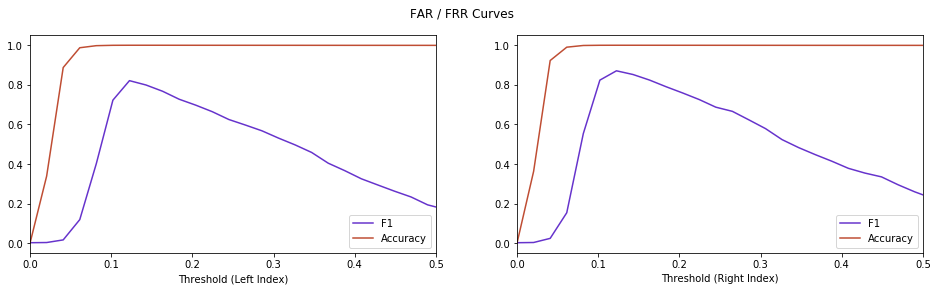

In [36]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
from sklearn.metrics import f1_score, accuracy_score
thresholds = np.linspace(0.0,1.0,50).tolist() # Hint: evaluating for ± 50 threshold values should suffice
li_f1_scores = [f1_score(li_genuine_id, np.where(li_scores >= t, 1, 0)) for t in thresholds]
li_accuracy_scores = [accuracy_score(li_genuine_id, np.where(li_scores >= t, 1, 0)) for t in thresholds]
ri_f1_scores = [f1_score(ri_genuine_id, np.where(ri_scores >= t, 1, 0)) for t in thresholds]
ri_accuracy_scores = [accuracy_score(ri_genuine_id, np.where(ri_scores >= t, 1, 0)) for t in thresholds]
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('FAR / FRR Curves')
axes[0].plot(thresholds, li_f1_scores, color=(0.4,0.2,0.8), label='F1')
axes[0].plot(thresholds, li_accuracy_scores, color=(0.75,0.3,0.2), label='Accuracy')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].plot(thresholds, ri_f1_scores, color=(0.4,0.2,0.8), label='F1')
axes[1].plot(thresholds, ri_accuracy_scores, color=(0.75,0.3,0.2), label='Accuracy')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();
plt.show()

*The accuracy increases until a threshold where the bulk of the imposters are effectively considered imposters. Then it drops as it keeps mislabeling more and more genuine scores. Since there are many more imposter than genuine scores the accuracy barely seems to change, however, whereas the F1 score visibly decreases.*

In [57]:
"""Calculate the threshold for which F1 is maximal."""
li_max_f1_t = thresholds[li_f1_scores.index(max(li_f1_scores))]
ri_max_f1_t = thresholds[ri_f1_scores.index(max(ri_f1_scores))]
print("Max F1 score at threshold = %f (Left Index)." % li_max_f1_t)
print("Accuracy at this threshold = %f." % accuracy_score(li_genuine_id, np.where(li_scores >= li_max_f1_t, 1, 0)))
print("Max F1 score at threshold = %f (Right Index)." % ri_max_f1_t)
print("Accuracy at this threshold = %f." % accuracy_score(ri_genuine_id, np.where(ri_scores >= ri_max_f1_t, 1, 0)))
print("Maximum imposter score %f" % max(li_scores[li_genuine_id < 1]))

Max F1 score at threshold = 0.122449 (Left Index).
Accuracy at this threshold = 0.999683.
Max F1 score at threshold = 0.122449 (Right Index).
Accuracy at this threshold = 0.999766.
Maximum imposter score 0.175573


TODO

In [40]:
"""Do the same for the classification error (or accuracy)"""
print("Max Accuracy score at threshold %f (Left Index)." % thresholds[li_accuracy_scores.index(max(li_accuracy_scores))])
print("Max Accuracy score at threshold %f (Right Index)." % thresholds[ri_accuracy_scores.index(max(ri_accuracy_scores))])

Max Accuracy score at threshold 0.122449 (Left Index).
Max Accuracy score at threshold 0.122449 (Right Index).


*Clearly, accuracy doesn't deal well with the class imbalance that happens to be common in biometrics. A threshold of 0.9 would render the system rather useless yet its accuracy would still be high.*

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

#### <font color=blue> Task 1.4 Calculate and discuss AUC and EER and alternatives

* Calculate ROC AUC. 
 * Does it reveal anything about the performance of the system?
* Calculate (by approximation) the EER and plot it on the FAR-FRR curve.
 * Would you consider this a good operating point?
* Calculate the decision threshold for which the sum of FRR and FAR is minimal. 
 * Is it similar to the total classification error?
* Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.
        
</font>

In [34]:
"""Calculate the ROC AUC."""
from sklearn.metrics import roc_auc_score
print("ROC AUC (Left Index) = % f" % roc_auc_score(li_genuine_id, li_scores))
print("ROC AUC (Right Index) = % f" % roc_auc_score(ri_genuine_id, ri_scores))

ROC AUC (Left Index) =  0.971247
ROC AUC (Right Index) =  0.982661


*The AUC gives some idea about the performance of the system and can be used to compare two systems. It doesn't give the full picture, as a system could still outperform a system with a higher AUC at certain thresholds. The ROC curve itself can be inspected for this reason.*

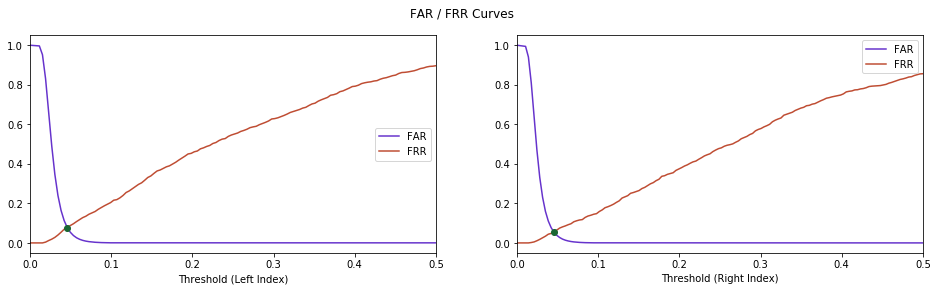

In [71]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""

# Calculate index in array where difference between FNR and FPR is smallest
#  - you can use an interpolated or discrete approximation, both are fine
#  - avoid using a library for this assignment 
li_differences = [abs((1-x)-y) for (x,y) in zip(li_tpr, li_fpr)]
li_min_index = li_differences.index(min(li_differences))
ri_differences = [abs((1-x)-y) for (x,y) in zip(ri_tpr, ri_fpr)]
ri_min_index = ri_differences.index(min(ri_differences))
#li_min_index = np.nanargmin(np.absolute(((1-li_tpr) - li_fpr)))
#ri_min_index = np.nanargmin(np.absolute(((1-ri_tpr) - ri_fpr)))

# Plot EER
figure, axes = plt.subplots(ncols=2, figsize=(16,4))
figure.suptitle('FAR / FRR Curves')
axes[0].scatter(li_thresholds[li_min_index], li_fpr[li_min_index], color=(0.1,0.4,0.2), zorder=3)
axes[0].plot(li_thresholds, li_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[0].plot(li_thresholds, 1-li_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[0].set(xlabel='Threshold (Left Index)', xlim=[0.0,0.5])
axes[0].legend();
axes[1].scatter(ri_thresholds[ri_min_index], ri_fpr[ri_min_index], color=(0.1,0.4,0.2), zorder=3)
axes[1].plot(ri_thresholds, ri_fpr, color=(0.4,0.2,0.8), label='FAR')
axes[1].plot(ri_thresholds, 1-ri_tpr, color=(0.75,0.3,0.2), label='FRR')
axes[1].set(xlabel='Threshold (Right Index)', xlim=[0.0,0.5])
axes[1].legend();

In [72]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
li_sums = [abs((1-x)+y) for (x,y) in zip(li_tpr, li_fpr)]
ri_sums = [abs((1-x)+y) for (x,y) in zip(ri_tpr, ri_fpr)]
print('Minimum threshold (Left Index) : % f' % li_thresholds[li_sums.index(min(li_sums))])
print('Minimum threshold (Left Index) : % f' % ri_thresholds[ri_sums.index(min(ri_sums))])

Minimum threshold (Left Index) :  0.057252
Minimum threshold (Left Index) :  0.059441


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


#### <font color=blue> Task 1.5 Experiment with Precision-Recall curves and related summary measures

* Calculate and plot the Precision-Recall curve for this system. 
 * What does it reveal about the performance of the system?
* Calculate the Area Under the PR-curve. 
 * Discuss.
* Calculate the average precision scores. 
 * discuss its value.
        
</font>

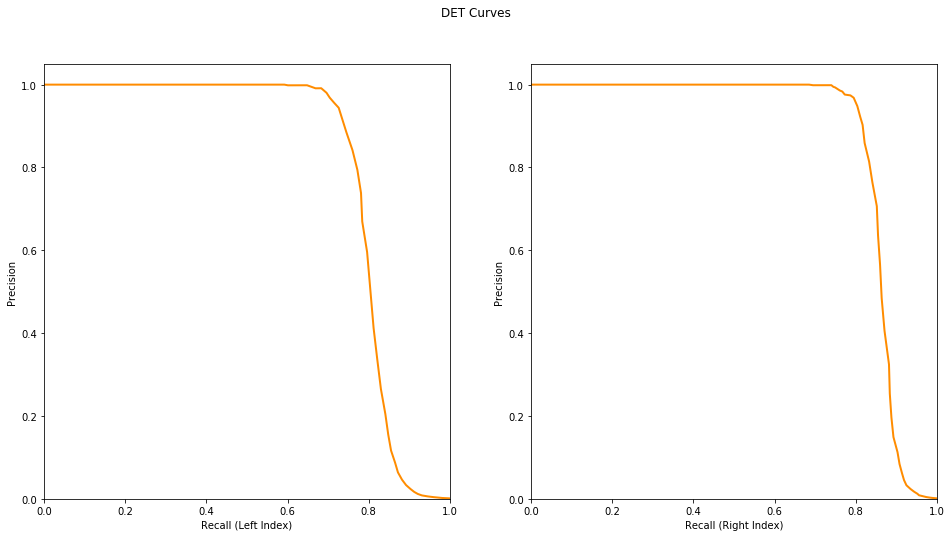

In [75]:
"""Calculate and plot the Precision-Recall curve for this system"""

# Calculate PR curve
from sklearn.metrics import precision_recall_curve
li_precision, li_recall, _ = precision_recall_curve(li_genuine_id, li_scores)
ri_precision, ri_recall, _ = precision_recall_curve(ri_genuine_id, ri_scores)

# Plot PR curve
figure, axes = plt.subplots(ncols=2, figsize=(16,8))
figure.suptitle('DET Curves')
axes[0].plot(li_recall, li_precision, color='darkorange', lw=2)
axes[0].set(xlabel='Recall (Left Index)', ylabel='Precision', xlim=[0.0,1.0], ylim=[0.0,1.05])
axes[1].plot(ri_recall, ri_precision, color='darkorange', lw=2)
axes[1].set(xlabel='Recall (Right Index)', ylabel='Precision', xlim=[0.0,1.0], ylim=[0.0,1.05])
plt.show()

In [76]:
"""Calculate the Area Under the PR-curve."""
from sklearn.metrics import auc
print('AUC (Left Index) : % f' % auc(li_recall, li_precision))
print('AUC (Right Index) : % f' % auc(ri_recall, ri_precision))

AUC (Left Index) :  0.803478
AUC (Right Index) :  0.862757


In [77]:
"""Calculate the average precision scores"""
from sklearn.metrics import average_precision_score
print('AUC (Left Index) : % f' % average_precision_score(li_genuine_id, li_scores))
print('AUC (Right Index) : % f' % average_precision_score(ri_genuine_id, ri_scores))

AUC (Left Index) :  0.798897
AUC (Right Index) :  0.859512


## Validation of identification  

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



#### <font color=blue> Task 1.6 Experiment with CMC

* Calculate the Cumulative Matching Characteristic curve (implement this yourself)
* Compute the Rank-1 Recognition Rate.
        
</font>

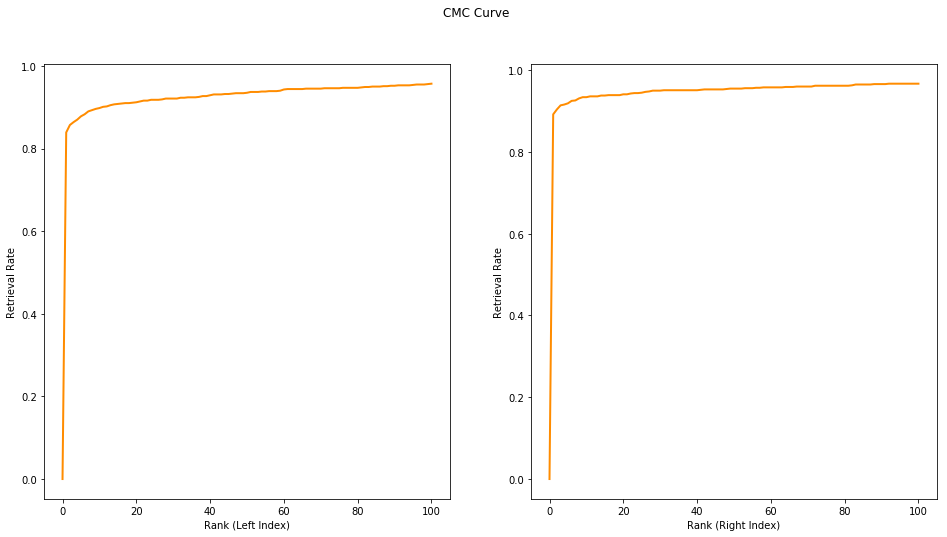

In [106]:
"""Calculate the Cumulative Matching Characteristic curve."""
def CMC(similarity_matrix, n_ranks):
    # 1.1) compute the rank of the column elements (enrollees) for every row (user)
    # 1.2) calculate how frequent each rank occurs on the diagonal (diagonal contains the correct identifications)
    cmc = [0] * n_ranks
    for (i,row) in enumerate(similarity_matrix):
        rank = sorted(row, reverse=True).index(row[i])
        if rank < n_ranks:
            cmc[rank] += 1
    # 1.3) compute the cumulative frequency for each rank and normalise the result 
    # 1.4) return the CMC
    prev = 0
    for i in range(n_ranks):
        prev = cmc[i] + prev
        cmc[i] = prev / 1000
    return [0] + cmc

# 1) compute the CMC for the first ±100 ranks
n_ranks = 100
li_cmc = CMC(li_similarity_matrix.values.tolist(), n_ranks)
ri_cmc = CMC(ri_similarity_matrix.values.tolist(), n_ranks)

# 2) plot the probability of recognition in function of the rank
figure, axes = plt.subplots(ncols=2, figsize=(16,8))
figure.suptitle('CMC Curve')
axes[0].plot(list(range(n_ranks+1)), li_cmc, color='darkorange', lw=2)
axes[0].set(xlabel='Rank (Left Index)', ylabel='Retrieval Rate')
axes[1].plot(list(range(n_ranks+1)), ri_cmc, color='darkorange', lw=2)
axes[1].set(xlabel='Rank (Right Index)', ylabel='Retrieval Rate')
plt.show()

In [108]:
"""compute the Rank-1 Recognition Rate."""
print('Rank-1 Recognition Rate (Left Index) : % f' % li_cmc[1])
print('Rank-1 Recognition Rate (Right Index) : % f' % ri_cmc[1])

Rank-1 Recognition Rate (Left Index) :  0.839000
Rank-1 Recognition Rate (Right Index) :  0.892000


#### <font color=blue> Task 1.7 Evaluate different biometric systems
    
With all above plots and metrics, you can start comparing different biometric systems (same biometric with different implementation, or different biometrics) in an authentication/verification and identification scenario. 
    
* Do this for comparing the left index from the right index finger.
* Do you see any differences in any of the curves or measures?
        
</font>